In [1]:
import sqlite3
import os
import pandas as pd
import datetime
from datetime import date
from numpy import NaN
import seaborn as sns

connexion = sqlite3.connect("input_data/bce.db")
cursor = connexion.cursor()

## Import all needed tables
The data come from fgov
voir documentation : https://economie.fgov.be/sites/default/files/Files/Entreprises/BCE/Cookbook-BCE-Open-Data.pdf
documentation 2: https://economie.fgov.be/sites/default/files/Files/Entreprises/BCE/Manuel-technique-reutilisation-des-donnees-BCE.pdf

In [2]:
cursor = cursor.execute( 
    """
    SELECT Category
    from code
    Group by Category
    """
)
result = cursor.fetchall()
col = [description[0] for description in cursor.description]
code = pd.DataFrame.from_records(data=result, columns=col)
category = list(code['Category'].T)

In [3]:
code_tbls = {}
for table_name in category:
    cursor.execute( f"""
        Select  Code, Description
        from code
        where code.Category = "{table_name}" AND code."Language"="FR";
        """
    )
    result = cursor.fetchall()
    col = [description[0] for description in cursor.description]
    code_tbls[table_name] = pd.DataFrame.from_records(data=result, columns=col)


In [4]:
cursor.execute("""
Select *
FROM enterprise
""")
enterprise = cursor.fetchall()
col = [description[0] for description in cursor.description]
enterprise = pd.DataFrame.from_records(data=enterprise, columns=col)


In [5]:
cursor.execute("""
Select *
FROM establishment
""")
establishment = cursor.fetchall()
col = [description[0] for description in cursor.description]
establishment = pd.DataFrame.from_records(data=establishment, columns=col)

In [6]:
dict_tbl = {}
list_key = [ 'JuridicalSituation', 'JuridicalForm', 'TypeOfEnterprise']

for key in list_key:
     dict_tbl[key] = code_tbls[key]

for tbls_name, tbls in dict_tbl.items():
    enterprise = enterprise.set_index(tbls_name).join(tbls.set_index('Code'), how='left')\
         .rename(columns={'Description' : tbls_name})

## QUestion 1 what is the repartition of the companies Status ?
All entreprises are Active as non actives are removed from the list.
Further analysis could be done on a time dimention with a define time laps to see the number of compnies that whent from active to unactive.
see if data available otherwise when data update see what are the removed companies


In [7]:
enterprise

,EnterpriseNumber,Status,StartDate,JuridicalSituation,JuridicalForm,TypeOfEnterprise
1,0500.017.677,AC,2016-01-01 00:00:00,Situation normale,NaN,Personne physique
1,0500.044.797,AC,1800-01-01 00:00:00,Situation normale,NaN,Personne physique
1,0500.081.916,AC,1971-01-01 00:00:00,Situation normale,NaN,Personne physique
1,0500.083.993,AC,1965-01-01 00:00:00,Situation normale,NaN,Personne physique
1,0500.085.082,AC,2021-04-01 00:00:00,Situation normale,NaN,Personne physique
...,...,...,...,...,...,...
2,0859.371.993,AC,1986-07-01 00:00:00,Situation normale,Forme légale inconnue (ONSS),Personne morale
2,0859.372.092,AC,2000-07-01 00:00:00,Situation normale,Forme légale inconnue (ONSS),Personne morale
2,0859.380.804,AC,1982-07-01 00:00:00,Situation normale,Forme légale inconnue (ONSS),Personne morale
2,0850.392.169,AC,1970-01-01 00:00:00,Dissolution de plein droit par arrivée du terme,Forme légale inconnue (ONSS),Personne morale


## Question 2 juridical Form / situation

In [8]:
JurSit_repartition = (enterprise.groupby('JuridicalSituation')['EnterpriseNumber']
                .count()
                .reset_index(name='nmb_JurSit') )

# creation of a list of names with the goal to see it distribution 
JuridicalSituation_names = list(JurSit_repartition['JuridicalSituation'].T)

#repartition per category in %
JurSit_repartition['%']=JurSit_repartition['nmb_JurSit']/enterprise['EnterpriseNumber'].count()*100

#remove the other en create a separate frame
JurSit_repartition.loc[JurSit_repartition['JuridicalSituation'].isin(['Dissolution anticipée - Liquidation (dissolution volontaire)','Ouverture de faillite','Situation normale']),'cleaned_JuridicalSituation']= JurSit_repartition['JuridicalSituation']
JurSit_repartition.loc[~JurSit_repartition['JuridicalSituation'].isin(['Dissolution anticipée - Liquidation (dissolution volontaire)','Ouverture de faillite','Situation normale']),'cleaned_JuridicalSituation']= 'other'

#select only values that is = other
Fig_JuridicalSituation_others = JurSit_repartition.loc[JurSit_repartition['cleaned_JuridicalSituation']=='other']

# fig of values per juridiction
Fig_JuridicalSituation = JurSit_repartition.groupby('cleaned_JuridicalSituation')['%'].sum().reset_index(name=('%'))



In [9]:
Fig_JuridicalSituation

,cleaned_JuridicalSituation,%
0,Dissolution anticipée - Liquidation (dissoluti...,1.386095
1,Ouverture de faillite,4.010751
2,Situation normale,94.210784
3,other,0.392370


In [10]:
JurForm_repartition = (enterprise.groupby('JuridicalForm')['EnterpriseNumber']
                .count()
                .reset_index(name='nmb_JurForm') )


#repartition per category in %
JurForm_repartition['%']=JurForm_repartition['nmb_JurForm']/enterprise['EnterpriseNumber'].count()*100

JurForm_repartition = JurForm_repartition.sort_values(by=['%'],ascending=False ).head(20)
# creation of a list of names with the goal to see it distribution 
JuridicalForm_names = list(JurForm_repartition['JuridicalForm'].T)

#remove the other en create a separate frame
selection = ['Société privée à responsabilité limitée',
            'Société à responsabilité limitée',
            'Association sans but lucratif',
            'Société anonyme',
            'Association des copropriétaires',
            'Entité étrangère']

JurForm_repartition.loc[JurForm_repartition['JuridicalForm'].isin(selection),'cleaned_JuridicalForm']= JurForm_repartition['JuridicalForm']
JurForm_repartition.loc[~JurForm_repartition['JuridicalForm'].isin(selection),'cleaned_JuridicalForm']= 'other'

#select only values that is = other
Fig_JuridicalForm_others = JurForm_repartition.loc[JurForm_repartition['cleaned_JuridicalForm']=='other']

# fig of values per juridiction
Fig_JuridicalForm = JurForm_repartition.groupby('cleaned_JuridicalForm')['%'].sum().reset_index(name=('%'))

In [11]:
Fig_JuridicalForm

,cleaned_JuridicalForm,%
0,Association des copropriétaires,5.045640
1,Association sans but lucratif,7.533709
2,Entité étrangère,3.320736
3,Société anonyme,5.315055
4,Société privée à responsabilité limitée,19.133287
5,Société à responsabilité limitée,9.156214
6,other,8.764327


In [12]:
#select only values that is = other
Fig_JuridicalSituation_others = JurSit_repartition.loc[JurSit_repartition['cleaned_JuridicalSituation']=='other']
# fig of values per juridiction
Fig_JuridicalSituation = JurSit_repartition.groupby('cleaned_JuridicalSituation')['%'].sum()

## Question 3 Which percentage of the companies are which type of entreprise?

In [13]:
Types_of_companies = (enterprise.groupby('TypeOfEnterprise')['EnterpriseNumber']
                .count()
                .reset_index(name='nmb_JurSit') )
Types_of_companies['%']=Types_of_companies['nmb_JurSit']/enterprise['EnterpriseNumber'].count()*100
Types_of_companies

,TypeOfEnterprise,nmb_JurSit,%
0,Personne morale,1099649,59.016461
1,Personne physique,763643,40.983539


## Question 4 What is the average company's age in each sector (hint: look what is the NACE code)?

In [14]:
import math
import numpy as np
#define the age of the company
def round_10(x):
    return np.ceil(x/10)*10

today_date = datetime.datetime.now().date()
enterprise['StartDate']= pd.to_datetime(enterprise['StartDate']).dt.date
enterprise['Age']= (today_date-enterprise['StartDate'])
enterprise['Age'] = (enterprise['Age'].dt.days/365).round()
enterprise['Age_10'] = enterprise['Age'].apply(round_10)

In [15]:
enterprise

,EnterpriseNumber,Status,StartDate,JuridicalSituation,JuridicalForm,TypeOfEnterprise,Age,Age_10
1,0500.017.677,AC,2016-01-01,Situation normale,NaN,Personne physique,7.0,10.0
1,0500.044.797,AC,1800-01-01,Situation normale,NaN,Personne physique,223.0,230.0
1,0500.081.916,AC,1971-01-01,Situation normale,NaN,Personne physique,52.0,60.0
1,0500.083.993,AC,1965-01-01,Situation normale,NaN,Personne physique,58.0,60.0
1,0500.085.082,AC,2021-04-01,Situation normale,NaN,Personne physique,2.0,10.0
...,...,...,...,...,...,...,...,...
2,0859.371.993,AC,1986-07-01,Situation normale,Forme légale inconnue (ONSS),Personne morale,36.0,40.0
2,0859.372.092,AC,2000-07-01,Situation normale,Forme légale inconnue (ONSS),Personne morale,22.0,30.0
2,0859.380.804,AC,1982-07-01,Situation normale,Forme légale inconnue (ONSS),Personne morale,40.0,40.0
2,0850.392.169,AC,1970-01-01,Dissolution de plein droit par arrivée du terme,Forme légale inconnue (ONSS),Personne morale,53.0,60.0


In [16]:
Query_activity = """
    SELECT EntityNumber, substr(NaceCode,1,2) Industry, NaceVersion, ActivityGroup, Classification
    FROM activity
    GROUP BY EntityNumber , Industry, NaceVersion, ActivityGroup, Classification
"""

cursor.execute(Query_activity)
activity = cursor.fetchall()
col = [description[0] for description in cursor.description]

activity = pd.DataFrame.from_records(data=activity, columns=col)

### Check the not na when merging entreprise number in entreprise en activity

In [17]:
activity_EntNum = activity['EntityNumber'].drop_duplicates()

#Check ENtreprise nbr without activity linked
a = enterprise['EnterpriseNumber']
b = activity_EntNum
left_a_b = pd.merge(a,b,left_on='EnterpriseNumber', right_on='EntityNumber',how='left')
Left_a_b_nona = left_a_b[left_a_b['EntityNumber'].notna()]

#Check ENtreprise nbr without activity linked
left_a_b_Na = left_a_b[left_a_b['EntityNumber'].isna()]
Ent_withoutactiv = pd.merge(left_a_b_Na,enterprise,on='EnterpriseNumber',how='left')
Ent_withoutactiv

,EnterpriseNumber,EntityNumber,Status,StartDate,JuridicalSituation,JuridicalForm,TypeOfEnterprise,Age,Age_10
0,0500.044.797,NaN,AC,1800-01-01,Situation normale,NaN,Personne physique,223.0,230.0
1,0500.083.993,NaN,AC,1965-01-01,Situation normale,NaN,Personne physique,58.0,60.0
2,0500.122.201,NaN,AC,1969-11-01,Situation normale,NaN,Personne physique,53.0,60.0
3,0500.153.081,NaN,AC,1973-03-01,Situation normale,NaN,Personne physique,50.0,50.0
4,0500.181.785,NaN,AC,1975-08-01,Situation normale,NaN,Personne physique,47.0,50.0
...,...,...,...,...,...,...,...,...,...
683112,0859.371.993,NaN,AC,1986-07-01,Situation normale,Forme légale inconnue (ONSS),Personne morale,36.0,40.0
683113,0859.372.092,NaN,AC,2000-07-01,Situation normale,Forme légale inconnue (ONSS),Personne morale,22.0,30.0
683114,0859.380.804,NaN,AC,1982-07-01,Situation normale,Forme légale inconnue (ONSS),Personne morale,40.0,40.0
683115,0850.392.169,NaN,AC,1970-01-01,Dissolution de plein droit par arrivée du terme,Forme légale inconnue (ONSS),Personne morale,53.0,60.0


In [18]:
a = enterprise
b = activity
inner_activity_entreprise = pd.merge(a,b,left_on='EnterpriseNumber', right_on='EntityNumber',how='left')


In [19]:
entreprise_activities_main = inner_activity_entreprise[inner_activity_entreprise['Classification']\
                                                .isin(['MAIN',NaN])]\
                                                .sort_values(by=['EnterpriseNumber','ActivityGroup','NaceVersion'])\
                                                .drop_duplicates(subset=['EnterpriseNumber','ActivityGroup'],keep="last")

In [120]:
entreprise_activities = inner_activity_entreprise.sort_values(by=['EnterpriseNumber','Industry', 'ActivityGroup','Classification','NaceVersion'])\
                                                .drop_duplicates(subset=['EnterpriseNumber','Industry','ActivityGroup', 'Classification'],keep="last")

In [117]:
map_2003 = pd.read_csv("input_data/mapping_sector_2003.csv")
map_2003['code_sector'] = map_2003['code_sector'].astype(str).str.zfill(2)
map_2003 = map_2003[['code_sector','letter_sector']]
map_2008 = pd.read_csv("input_data/mapping_sector_2008.csv")
map_2008['code_sector'] = map_2008['code_sector'].astype(str).str.zfill(2)
map_2008 = map_2008[['code_sector','letter_sector']]

In [121]:
a = entreprise_activities[entreprise_activities['NaceVersion']=='2008']
b = code_tbls['Nace2008']
c = map_2008
d = map_2003

Nace2008 = pd.merge(a,b,left_on='Industry', right_on='Code',how='left')\
                .merge(c,left_on='Industry', right_on='code_sector',how='left' )

a = entreprise_activities[entreprise_activities['NaceVersion']=='2003']
b = code_tbls['Nace2003']
Nace2003 = pd.merge(a,b,left_on='Industry', right_on='Code',how='left')\
                .merge(d,left_on='Industry', right_on='code_sector',how='left' )

a = entreprise_activities[entreprise_activities['NaceVersion'].isna()]
b = code_tbls['Nace2003']
NaceNaN= pd.merge(a,b,left_on='Industry', right_on='Code',how='left')

entreprise_activities = pd.concat([Nace2008, Nace2003, NaceNaN])
entreprise_activities = entreprise_activities[['EnterpriseNumber','StartDate','JuridicalSituation','JuridicalForm','TypeOfEnterprise','Age','Age_10','NaceVersion','ActivityGroup','code_sector','Description', 'letter_sector']]


In [122]:
entreprise_activities

,EnterpriseNumber,StartDate,JuridicalSituation,JuridicalForm,TypeOfEnterprise,Age,Age_10,NaceVersion,ActivityGroup,code_sector,Description,letter_sector
0,0200.065.765,1960-08-09,Situation normale,Association prestataire de services (Région fl...,Personne morale,62.0,70.0,2008,001,41,Construction de bâtiments; promotion immobilière,F
1,0200.065.765,1960-08-09,Situation normale,Association prestataire de services (Région fl...,Personne morale,62.0,70.0,2008,006,84,Administration publique et défense; sécurité s...,O
2,0200.068.636,1923-02-16,Situation normale,Association chargée de mission (Région flamande),Personne morale,100.0,100.0,2008,001,36,"Captage, traitement et distribution d'eau",E
3,0200.068.636,1923-02-16,Situation normale,Association chargée de mission (Région flamande),Personne morale,100.0,100.0,2008,006,36,"Captage, traitement et distribution d'eau",E
4,0200.068.636,1923-02-16,Situation normale,Association chargée de mission (Région flamande),Personne morale,100.0,100.0,2008,001,93,"Activités sportives, récréatives et de loisirs",R
...,...,...,...,...,...,...,...,...,...,...,...,...
683112,0998.603.023,1992-01-01,Situation normale,Entité étrangère avec un bien immobilier en Be...,Personne morale,31.0,40.0,NaN,NaN,NaN,NaN,NaN
683113,0998.603.518,2001-01-01,Situation normale,Entité étrangère avec un bien immobilier en Be...,Personne morale,22.0,30.0,NaN,NaN,NaN,NaN,NaN
683114,0998.603.617,2001-01-01,Situation normale,Entité étrangère avec un bien immobilier en Be...,Personne morale,22.0,30.0,NaN,NaN,NaN,NaN,NaN
683115,0998.604.211,2001-09-15,Situation normale,Entité étrangère avec un bien immobilier en Be...,Personne morale,21.0,30.0,NaN,NaN,NaN,NaN,NaN


In [43]:
df = entreprise_activities[entreprise_activities['StartDate']!=pd.to_datetime('1800-01-01')]

/tmp/ipykernel_33868/3018129483.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df = entreprise_activities[entreprise_activities['StartDate']!=pd.to_datetime('1800-01-01')]


In [116]:
df.groupby(['letter_sector','title_sector'])['EnterpriseNumber'].count().reset_index().

,letter_sector,title_sector,EnterpriseNumber
0,A,"Agriculture, chasse et sylviculture",12730
1,A,"Agriculture, sylviculture et pêche",81421
2,B,Industries extractives,615
3,B,Pêche,254
4,C,Industrie manufacturière,144785
5,CA,Industries extractives,48
6,CB,Industries extractives,344
7,D,"Production et distribution d'électricité, de g...",3809
8,DA,Industrie manufacturière,7518
9,DB,Industrie manufacturière,2862


In [24]:
#df.groupby(['title_sector'], as_index=False).agg({'Age':['mean','median'], 'EnterpriseNumber':'count'})

In [47]:
median_age_sector = df.groupby(['letter_sector'])['Age'].mean().reset_index('letter_sector')

,letter_sector,Age
0,A,20.483362
1,B,29.118527
2,C,14.033636
3,CA,42.979167
4,CB,39.744186
5,D,10.546075
6,DA,30.836127
7,DB,32.517820
8,DC,31.227513
9,DD,28.694645


<AxesSubplot: ylabel='letter_sector'>

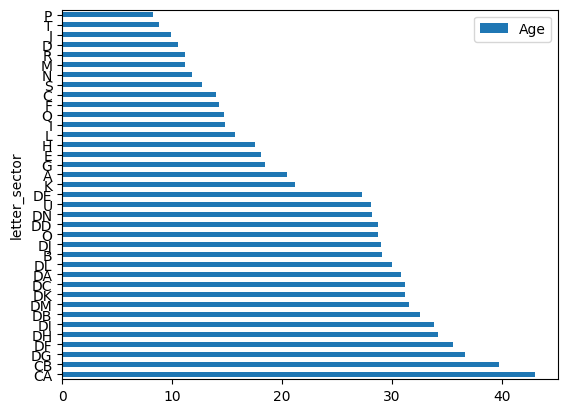

In [48]:
median_age_sector.sort_values('Age',ascending=False).set_index('letter_sector').plot(kind='barh')

### Regarding the Entreprise without Activities ??
further analysis has been made to see if establishement could fill the missing entreprise number but every establishement as a entreprise number in the table entreprise. (except 4 observation). see here under SQL command 

Select count(EstablishmentNumber)
FROM establishment
INNER JOIN (
	Select EnterpriseNumber as r_EnterpriseNumber
	FROM enterprise
	)
ON EnterpriseNumber = r_EnterpriseNumber
WHERE r_EnterpriseNumber NOTNULL  

Entreprises without an activity 683117


In [50]:
df.head(2)

,EnterpriseNumber,StartDate,JuridicalSituation,JuridicalForm,TypeOfEnterprise,Age,Age_10,NaceVersion,ActivityGroup,code_sector,Description,letter_sector,title_sector
0,0200.065.765,1960-08-09,Situation normale,Association prestataire de services (Région fl...,Personne morale,62.0,70.0,2008,001,41,Construction de bâtiments; promotion immobilière,F,Construction
1,0200.065.765,1960-08-09,Situation normale,Association prestataire de services (Région fl...,Personne morale,62.0,70.0,2008,006,84,Administration publique et défense; sécurité s...,O,Administration publique


In [100]:
ages_sectors = df.groupby(['letter_sector','Age_10'])['EnterpriseNumber'].count().unstack().reset_index().set_index('letter_sector')

ages_sectors


Age_10,0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,...,120.0,130.0,140.0,150.0,160.0,210.0,170.0,200.0,180.0,220.0
letter_sector,,,,,,,,,,,,,,,,,,,,,
A,183.0,29287.0,23398.0,17508.0,13727.0,4438.0,5443.0,88.0,32.0,14.0,...,2.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
B,2.0,160.0,149.0,200.0,177.0,84.0,51.0,7.0,8.0,5.0,...,6.0,1.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN
C,736.0,78689.0,29085.0,15646.0,12376.0,4240.0,2687.0,578.0,324.0,157.0,...,30.0,8.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
CA,NaN,1.0,11.0,10.0,8.0,3.0,7.0,1.0,NaN,1.0,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CB,NaN,2.0,48.0,88.0,82.0,52.0,36.0,7.0,8.0,2.0,...,4.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN
D,19.0,2485.0,813.0,206.0,129.0,59.0,69.0,9.0,8.0,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DA,1.0,133.0,1617.0,2376.0,2166.0,606.0,378.0,93.0,61.0,29.0,...,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DB,1.0,101.0,654.0,722.0,675.0,313.0,249.0,67.0,33.0,19.0,...,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DC,NaN,9.0,50.0,44.0,43.0,12.0,24.0,2.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Figure size 640x960 with 0 Axes>

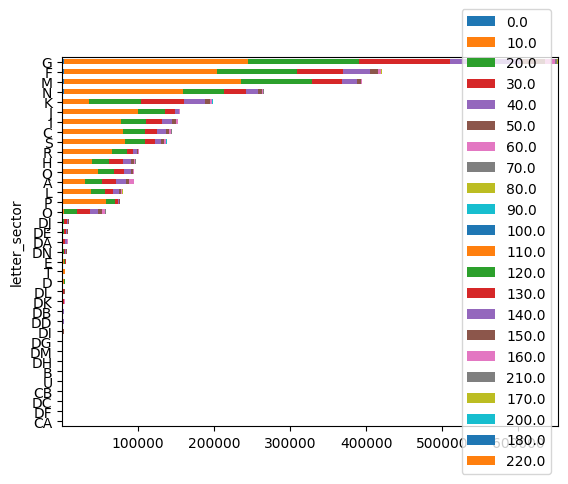

In [127]:
# importing matplotlib library
import matplotlib.pyplot as plt

s_sort = df.groupby('letter_sector')['EnterpriseNumber'].count().sort_values()
ages_sectors.reindex(index=s_sort.index ).reset_index().plot(x='letter_sector', stacked=True, kind='barh')
plt.legend(loc='right')

In [70]:
s_sort = df.groupby('letter_sector')['EnterpriseNumber'].count().sort_values(ascending=False)

In [102]:
s_sort


letter_sector
G     652769
F     420751
M     395070
N     265781
K     198445
J     155002
I     152828
C     144785
S     137715
R     101533
H      97048
Q      94766
A      94151
L      79892
P      76713
O      57950
DJ      9479
DE      7599
DA      7518
DN      6152
E       5657
T       4329
D       3809
DL      3357
DK      3312
DB      2862
DD      2633
DI      2156
DG      1380
DM      1165
DH      1032
B        869
U        370
CB       344
DC       189
DF        57
CA        48
Name: EnterpriseNumber, dtype: int64